Omnidirectional Spectra

In [ ]:
import numpy as np
from omnidirectional_spectrum import omnidirectional_spectrum, spectrum_model
wavenumbers=np.logspace(-3,5,500) #np.linspace(0.001,10000,10000000)
windspeeds=[10]#[4,8,12,16]

Pierson Moskowitz Spectrum

In [ ]:
PM_spectrum=omnidirectional_spectrum(spectrum_model.Pierson_Moskowitz, wavenumbers, windspeeds[0])
# PM_spectrum.plot()

JONSWAP Spectrum

In [ ]:
JONSWAP_spectrum=omnidirectional_spectrum(spectrum_model.JONSWAP, wavenumbers, windspeeds[0],F=25000)
# JONSWAP_spectrum.plot()

Elfouhaily Spectrum

In [ ]:
Elfouhaily_spectrum=omnidirectional_spectrum(spectrum_model.Elfouhaily, wavenumbers, windspeeds[0])
# Elfouhaily_spectrum.plot()

Spreading Functions

In [ ]:
from spreading_function import spreading_function, spreading_model
import numpy as np
theta=np.linspace(0,2*np.pi,200)
#theta=theta+np.pi/4

Simple Cosine Function

In [ ]:
simple_cosine_spread=spreading_function(spreading_model.Simple_Cosine,theta, n=2)
simple_cosine_spread.plot()

Longuet-Higgins

In [ ]:
longuet_higgins_spread=spreading_function(spreading_model.Longuet_Higgins,theta,S=8)
longuet_higgins_spread.plot()

Elfouhaily

In [ ]:
elfouhaily_spread=spreading_function(spreading_model.Elfouhaily,theta,k=0.1,F=25000)
elfouhaily_spread.plot()

Surface

In [ ]:
from surface import surfaceGenerator
size=(500, 500)
wind_direction=0
surfaceGenerator=surfaceGenerator(PM_spectrum[0],Simple_Cosine_Spreads[0], wavenumbers, theta, wind_direction,size, facet=2.5, seconds=0, delta_t=1)
surface=surfaceGenerator.generate()

In [ ]:
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
plt.imshow((surface[0,:,:]))
plt.gca().invert_yaxis()
#plt.xlim(0, size[0])
plt.colorbar()


In [ ]:
print(f"Variance {np.var(surface[0,:,:])}")
from scipy.integrate import quad
# print(quad(JONSWAP_Spectrum[0],*wavenumbers))
spectrum=JONSWAP_Spectrum[0]
spreading=LH_Spreads[0]
delta_k=np.diff(wavenumbers, prepend=wavenumbers[0])
delta_theta=np.diff(theta, prepend=theta[0])
A=spectrum.reshape(-1,1)*spreading#np.sqrt(2*spectrum.reshape(-1,1)*spreading*delta_k.reshape(-1,1)*delta_theta)
#aaa=np.trapz(A, k,axis=0)
print(f"Integral {np.trapz(np.trapz(A,wavenumbers, axis=0), x=theta, axis=0)}")
print(f"Significant wave height {4*np.sqrt(np.var(surface[0,:,:]))}")

In [ ]:
import numpy as np

Sx=np.gradient(surface[0,:,:],axis=0)
Sy=np.gradient(surface[0,:,:],axis=1)
# print(norm.cdf(Sx))
import matplotlib.pyplot as plt
plt.hist(Sx.flatten(), bins=50, density=True, alpha=0.5, label="Upwind Slopes");
plt.hist(Sy.flatten(), bins=50, density=True, alpha=0.5, label="Crosswind Slopes");
plt.legend()
print(f"Variance of slopes {np.var(Sx.flatten())+np.var(Sy.flatten())}")
A=(np.power(wavenumbers,2)*spectrum).reshape(-1,1)*spreading

print(f"Integral {np.trapz(np.trapz(A,wavenumbers, axis=0), x=theta, axis=0)}")      


In [3]:
from surface import surfaceGenerator

surfaceGenerator=surfaceGenerator(512, 2,100,0,5,0.5)
Z=surfaceGenerator.generate()


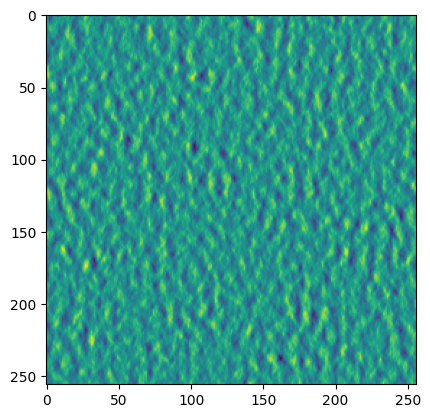

In [9]:
import matplotlib.pyplot as plt

plt.imshow(Z[5,:,:])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import omnidirectional_spectra
import spreading_functions
g=9.81
L=500
dx=2
N=int(L/dx)
x=np.linspace(-L/2,L/2,N)
y=np.linspace(-L/2,L/2,N)

kx_s = (2*np.pi*np.fft.fftfreq(N, dx)).astype(np.float32)
ky_s = (2*np.pi*np.fft.fftfreq(N, dx)).astype(np.float32)
kx, ky = np.meshgrid(kx_s, ky_s)

kx_res = kx[0, 1] - kx[0, 0]
ky_res = ky[1, 0] - ky[0, 0]

k = np.sqrt(kx**2 + ky**2)
good_k = np.where(k > np.min(np.array([kx_res, ky_res])) / 2.0)
kxn = np.zeros_like(kx, dtype=np.float32)
kyn = np.zeros_like(kx, dtype=np.float32)
kxn[good_k] = kx[good_k] / k[good_k]
kyn[good_k] = ky[good_k] / k[good_k]
kinv = np.zeros(k.shape, dtype=np.float32)
kinv[good_k] = 1./k[good_k]
theta = np.angle(np.exp(1j * (np.arctan2(ky, kx) ))).astype(np.float32)
omega = np.sqrt(np.float32(g) * k)
S = np.zeros(k.shape, dtype=np.float32)
D = np.zeros(k.shape, dtype=np.float32)
S[good_k] =omnidirectional_spectra.JONSWAP(k[good_k],10)
D[good_k] =spreading_functions.Longuet_Higgins(theta[good_k], 8)
wave_dirspec = (kinv) * S * D
np.random.seed(13)
random_cg = (1./np.sqrt(2) * (np.random.normal(0., 1., size=[N, N]) +1j * np.random.normal(0., 1., size=[N, N]))).astype(np.complex64)
wave_coefs=(N*N*np.sqrt(2.*wave_dirspec*kx_res*ky_res)*random_cg).astype(np.complex64)


In [ ]:
seconds=5
fps=30
frames=seconds*fps
time = np.arange(frames)*1/fps
Z=np.zeros((frames, N, N))
for frame, t in enumerate(time):
    wave_coefs_phased=(wave_coefs*np.exp(-1j*omega*t)).astype(np.complex64)
    Z[frame,:,:]=np.real(np.fft.ifft2(wave_coefs_phased))
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x, y, Z, cmap='ocean')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Height')
# ax.set_title('Wave Field')
# plt.show()

# plt.imshow(Z,extent=[0, L, 0, L])
# print(np.var(Z))

In [ ]:
# %matplotlib widget
# from matplotlib.animation import FuncAnimation
# fig, ax = plt.subplots()
# img = ax.imshow(Z[0,:,:], cmap='viridis',extent=[0, L, 0, L])
# # cbar=fig.colorbar(img)
# def update(frame):
#     img.set_array(Z[int(frame),:,:])  # Update the image data
#     ax.set_title(u"Frame {}°".format(frame))
#     return img,

# # Create the animation
# ani = FuncAnimation(fig, update, frames=np.arange(frames), interval=1000/fps, blit=True)

# plt.show()

In [ ]:
aaa=None
a=np.array([1,2,3,4,5])
print(a[aaa])